In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import unicodedata
import string
import re
import random
import torch

In [ ]:
print(torch.__version__)

1.5.1+cu101


In [ ]:
df = pd.read_csv("drive/My Drive/GPT/elon_musk.csv")

In [ ]:
index = list(df.text.isna()[data.text.isna() == True].index)

In [ ]:
data = df.text.drop(index,axis=0)

In [ ]:
data = data.to_list()

In [ ]:
## remove uneccesory text
def clean_tweet(tweet):
#     tweet = normalize('NFD', tweet).encode('ascii', 'ignore')
    tweet = str(tweet)
    tweet = re.sub('(RT\s(@\w+))', '', tweet)
    tweet = re.sub('@\\w+', '', tweet)
   
    tweet = re.sub('((http|https):(\S+))', '', tweet)
    tweet = re.sub('[!#?:*%$]', ' ', tweet)
    tweet = re.sub('[^\s\w+]', '', tweet)
    tweet = re.sub('[\n]', '', tweet)
    tweet = tweet.lower().strip()
    return tweet

In [ ]:
data_clean = list(map(lambda x: clean_tweet(x), data))

In [ ]:
EOS_token = 1

class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<blank>":0,"EOS":1}
        self.word2count = {}
        self.index2word = {0:"<blank>", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
vocab = Vocab("elon")

In [ ]:
# create a vocab for the data
for tweet in data_clean:
  vocab.addSentence(tweet)

In [ ]:
def tokenize(lang,sentence):
    
    sent = sentence + " " + "EOS"
    return [lang.word2index[word] for word in sent.split(' ')]

In [ ]:
data_token = list(map(lambda x: tokenize(vocab, x), data_clean))

In [ ]:
word_len = list(map(lambda x: len(x), data_token))

In [ ]:
MAX_LENGTH = max(word_len)

In [ ]:
MAX_LENGTH

60

In [ ]:
token_pad = np.zeros((len(data_token), MAX_LENGTH))

In [ ]:
for i,v in enumerate(data_token):
    
    for j, token in enumerate(v):
        
        token_pad[i,j] = token

In [ ]:
token_pad[0]

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       12., 15., 16., 17., 18., 19., 20., 14., 21., 22.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
valid = token_pad[:500]
train = token_pad[800:]

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train_data = TensorDataset(torch.from_numpy(train).long())

In [ ]:
valid_data = TensorDataset(torch.from_numpy(valid).long())

In [ ]:
batch_size = 100

train_loader= DataLoader(train_data,shuffle=True,batch_size=batch_size,)
valid_loader =DataLoader(valid_data,shuffle=True,batch_size=batch_size,)

In [ ]:
dataiter = iter(train_loader)
sample_x= dataiter.next()[0]

sample_x.shape

torch.Size([100, 60])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class Decoder(nn.Module):

  def __init__(self, layer, N):

    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self,x, tgt_mask):

    for layer in self.layers:
      x = layer(x, tgt_mask)
    return self.norm(x)

In [ ]:
class DecoderLayer(nn.Module):

  def __init__(self, size, self_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 2)

  def forward(self, x, tgt_mask):

    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    return self.sublayer[1](x, self.feed_forward)

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.gelu(self.w_1(x))))

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [ ]:
class GP(nn.Module):

  def __init__(self, decoder, tgt_embed, generator):
    super(GP, self).__init__()
    self.decoder = decoder
    self.embed = tgt_embed
    self.generator = generator

  def forward(self, x, x_mask):

    x = self.embed(x)
    x =  self.decoder(x,x_mask)

    return x

In [ ]:
def make_model(eng_vocab, N=12, d_model=768, d_ff=3072, h=12, dropout=0.1):

  c = copy.deepcopy
  attn = MultiHeadedAttention(h,d_model)
  ff   = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)


  model = GP(
      Decoder(DecoderLayer(d_model, c(attn), c(ff), dropout), N),
      nn.Sequential(Embeddings(d_model, eng_vocab), c(position)),
      Generator(d_model, eng_vocab)
  )

  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform(p)
  return model

In [ ]:
class Batch:

  def __init__(self, trg, pad=0):

    self.trg = trg[:, :-1]
    self.trg_y = trg[:, 1:]

    self.trg_mask = self.make_std_mask(self.trg,pad)

    self.ntokens = (self.trg_y !=pad).data.sum()

  @staticmethod
  def make_std_mask(tgt, pad):
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return tgt_mask


In [ ]:
def run_epoch(data_iter, model, loss_compute):

  start = time.time()
  total_tokens = 0
  total_loss = 0
  tokens = 0

  for i , data in enumerate(data_iter):

    trg = data[0]

    batch = Batch(trg.cuda())

    out = model.forward(batch.trg, batch.trg_mask)

    loss = loss_compute(out, batch.trg_y, batch.ntokens)

    total_loss += loss
    total_tokens += batch.ntokens
    tokens += batch.ntokens

    if i % 50 == 1:

      elapsed = time.time() - start
      print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
              (i, loss / batch.ntokens, tokens / elapsed))
      start = time.time()
      tokens = 0
  return total_loss / total_tokens

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

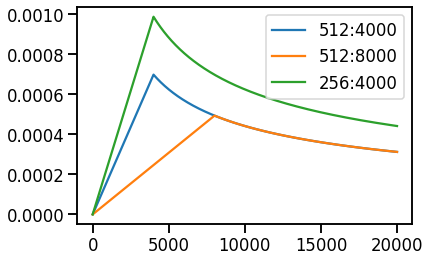

In [ ]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

In [ ]:
def greedy_decode(model, src, max_len):
    for i in range(max_len-1):
        out = model(Variable(src), 
                    Variable(subsequent_mask(src.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        src = torch.cat([src, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return src

In [ ]:
pad_idx = vocab.word2index["<blank>"]
model = make_model(vocab.n_words)
model.cuda()
criterion = LabelSmoothing(size=vocab.n_words,padding_idx=pad_idx,smoothing=0.1)
criterion.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


LabelSmoothing(
  (criterion): KLDivLoss()
)

In [ ]:
model_opt = NoamOpt(model.embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(70):
  model.train()
  
    
  run_epoch(train_loader,model,
           SimpleLossCompute(model.generator,criterion,model_opt))
  model.eval()
  print(run_epoch(valid_loader,model,
           SimpleLossCompute(model.generator,criterion,None)))

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Epoch Step: 1 Loss: 7.188176 Tokens per Sec: 616.605164
Epoch Step: 1 Loss: 7.030713 Tokens per Sec: 559.379517
tensor(7.0258, device='cuda:0')
Epoch Step: 1 Loss: 7.075574 Tokens per Sec: 718.628540
Epoch Step: 1 Loss: 6.807343 Tokens per Sec: 564.475342
tensor(6.7730, device='cuda:0')
Epoch Step: 1 Loss: 6.803943 Tokens per Sec: 655.220520
Epoch Step: 1 Loss: 6.500838 Tokens per Sec: 556.737976
tensor(6.5055, device='cuda:0')
Epoch Step: 1 Loss: 6.594892 Tokens per Sec: 636.391052
Epoch Step: 1 Loss: 6.253706 Tokens per Sec: 537.631165
tensor(6.3276, device='cuda:0')
Epoch Step: 1 Loss: 6.492273 Tokens per Sec: 637.713318
Epoch Step: 1 Loss: 6.252992 Tokens per Sec: 582.473694
tensor(6.1844, device='cuda:0')
Epoch Step: 1 Loss: 6.303047 Tokens per Sec: 656.761780
Epoch Step: 1 Loss: 6.067269 Tokens per Sec: 555.334534
tensor(6.0653, device='cuda:0')
Epoch Step: 1 Loss: 6.156277 Tokens per Sec: 643.956238
Epoch Step: 1 Loss: 5.893267 Tokens per Sec: 443.916199
tensor(5.9786, device='c

In [ ]:
def generate_word(words, max_len, model=model):

  token_word = torch.Tensor([vocab.word2index[word] for word in words]).long()
  tok_word = token_word[None, ...]

  model.eval()

  out = greedy_decode(model, tok_word, max_len=max_len)

  rslt = [vocab.index2word[item.item()] for item in out.data[0]]

  return " ".join(rslt)

In [ ]:
generate_word("spacex stock".split(), 22)

'spacex stock has 8000 employees in california washington texas  florida operating this entire time as we have national security exemption zero deaths'

In [ ]:
model.eval()
torch.save({
            'vocab':vocab,
            'model': model.state_dict()
            }, "drive/My Drive/GPT/gpt.pt")

In [ ]:
v = torch.load("drive/My Drive/GPT/gpt.pt")

In [ ]:
vo = v["vocab"]

In [ ]:
m = make_model(vocab.n_words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [ ]:
m.load_state_dict(v["model"])

<All keys matched successfully>

In [ ]:
generate_word("spacex stock".split(), 22,m)

'spacex stock has 8000 employees in california washington texas  florida operating this entire time as we have national security exemption zero deaths'